This is a Kaggle Challenge: TITANIC DISASTER - Link: https://www.kaggle.com/c/titanic

In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
from torchvision import datasets, transforms
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures

In [2]:
device = torch.device("cuda: 0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

In [3]:
TRAIN_DIR = "data/train.csv"
TEST_DIR = "data/test.csv"

In [4]:
MAKE_DATA = 1
PROCESS_DATA = 1
TRAIN_DATA = 1

In [5]:
#Visualize data
table = pd.read_csv(TRAIN_DIR)
display(HTML(table.to_html()))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,237736,30.0708,NaN,C


In [6]:
print(table.isnull().sum()) #Count empty cells (NaN)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [7]:
table = table.fillna(table.mean()) #Fill NaN cells with mean of the row

In [8]:
print(table.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [35]:
Y = table.iloc[:,1]
X = table.drop(["Survived","Name","Ticket","PassengerId","Embarked","Cabin"],axis = 1)
X.replace({'Sex':{'male' : 1, 'female': 0}},inplace = True)

     Pclass     Sex        Age  SibSp  Parch     Fare
0         3    male  22.000000      1      0   7.2500
1         1  female  38.000000      1      0  71.2833
2         3  female  26.000000      0      0   7.9250
3         1  female  35.000000      1      0  53.1000
4         3    male  35.000000      0      0   8.0500
..      ...     ...        ...    ...    ...      ...
886       2    male  27.000000      0      0  13.0000
887       1  female  19.000000      0      0  30.0000
888       3  female  29.699118      1      2  23.4500
889       1    male  26.000000      0      0  30.0000
890       3    male  32.000000      0      0   7.7500

[891 rows x 6 columns]


In [10]:
NUM_PASSENGER = len(Y)
print("Number of passengers: {}".format(NUM_PASSENGER))

Number of passengers: 891


In [11]:
BATCH_SIZE = NUM_PASSENGER
TRAINING_SAMPLES = 800
VAL_SAMPLES = 91

In [12]:
def Normalize_data(X):
    mean = np.mean(X,axis=0)                    #Mean of row
    std = np.std(X,axis=0)                      #Std of row
    X[:,1:] = (X[:,1:]-mean[1:])/std[1:]
    return X

In [13]:
#Make polynomial Features
def make_feature(X, poly=2):
    poly = PolynomialFeatures(poly)
    X_poly = poly.fit_transform(X)
    #print(X.shape)
    #print(X_poly.shape)
    return X_poly

In [14]:
X = np.array(X).reshape(X.shape[0], -1).astype(np.float32) #Convert into numpy array
Y = np.array(Y).reshape(-1,1)
X = make_feature(X,2)
X = Normalize_data(X)

In [15]:
NUM_PARAMETER = len(X[0])
print(NUM_PARAMETER)

28


In [16]:
#LogisticRegression
class LinearRegression(nn.Module):
    def __init__(self, inp):
        super(LinearRegression, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(inp,10),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(10,1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.main(x)
        

In [17]:
def training_step(model, optimizer, error, trainloader):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for (target, label) in trainloader:
        model.zero_grad()
        target = Variable(target).view(-1,NUM_PARAMETER).to(device)
        label = Variable(label).view(-1,1).to(device)
        #one_hot_label = one_hot[label]
        #one_hot_label = Variable(one_hot_label).to(device)
        
        outputs = model(target)
        
        prediction = 1 if outputs.data>0.5 else 0 #torch.max(outputs.data, 1)[1]

        loss = error(outputs, label.float())
        
        loss.backward()
        optimizer.step()
        train_loss += loss.data
        total += len(target)
        correct += (prediction == label).sum()
    acc = correct*1.0/total
    return train_loss, acc

In [18]:
def evaluating_step(model, optimizer, error, valloader):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for (target, label) in valloader:
            target = Variable(target).view(-1,NUM_PARAMETER).to(device)
            label = Variable(label).view(-1,1).to(device)
            #one_hot_label = one_hot[label]
            #one_hot_label = Variable(one_hot_label).to(device)
            outputs = model(target)
            prediction = 1 if outputs.data>0.5 else 0 #torch.max(outputs.data, 1)[1]
            loss = error(outputs, label.float())
            val_loss += loss.data
            total += len(target)
            correct += (prediction == label).sum()
        acc = correct*1.0/total
    return val_loss, acc

In [19]:
def plot(train_loss_list, train_acc_list, val_loss_list, val_acc_list, EPOCHS):
    fig = plt.figure(figsize=(20,5))
    fig.add_subplot(1,2,1)
    plt.plot(range(EPOCHS),train_loss_list, label = "Training Loss")
    plt.plot(range(EPOCHS),val_loss_list, color = "orange", label = "Validation Loss")
    plt.legend()
    fig.add_subplot(1,2,2)
    plt.plot(range(EPOCHS),train_acc_list, label = "Training Accuracy")
    plt.plot(range(EPOCHS),val_acc_list, color = "orange", label = "Validation Accuracy")
    plt.legend()
    plt.show()

In [20]:
def train(EPOCHS, model, optimizer, error, trainloader, valloader):
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    for epoch in range(EPOCHS):
        train_loss, train_acc = training_step(model,optimizer, error, trainloader)
        val_loss, val_acc = evaluating_step(model,optimizer, error, valloader)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        print("Epoch: ({}/{}), Train loss: {:3f}, Train Acc: {:3f}, Val loss: {:3f}, Val Acc: {:3f}".format(epoch+1,EPOCHS, train_loss,
                                                                                                train_acc, val_loss, val_acc))
    return model, train_loss_list, train_acc_list, val_loss_list, val_acc_list

Start training at fold: 1...
Epoch: (1/30), Train loss: 468.568481, Train Acc: 0.625000, Val loss: 110.556412, Val Acc: 0.726257
Epoch: (2/30), Train loss: 408.534546, Train Acc: 0.779494, Val loss: 98.903130, Val Acc: 0.776536
Epoch: (3/30), Train loss: 358.041626, Train Acc: 0.810393, Val loss: 91.083809, Val Acc: 0.810056
Epoch: (4/30), Train loss: 327.098999, Train Acc: 0.817416, Val loss: 86.936928, Val Acc: 0.810056
Epoch: (5/30), Train loss: 311.409637, Train Acc: 0.814607, Val loss: 85.052406, Val Acc: 0.804469
Epoch: (6/30), Train loss: 303.438538, Train Acc: 0.814607, Val loss: 84.254906, Val Acc: 0.810056
Epoch: (7/30), Train loss: 298.885193, Train Acc: 0.816011, Val loss: 83.875534, Val Acc: 0.810056
Epoch: (8/30), Train loss: 295.948700, Train Acc: 0.813202, Val loss: 83.713348, Val Acc: 0.815642
Epoch: (9/30), Train loss: 293.788239, Train Acc: 0.813202, Val loss: 83.640015, Val Acc: 0.815642
Epoch: (10/30), Train loss: 292.060669, Train Acc: 0.811798, Val loss: 83.61608

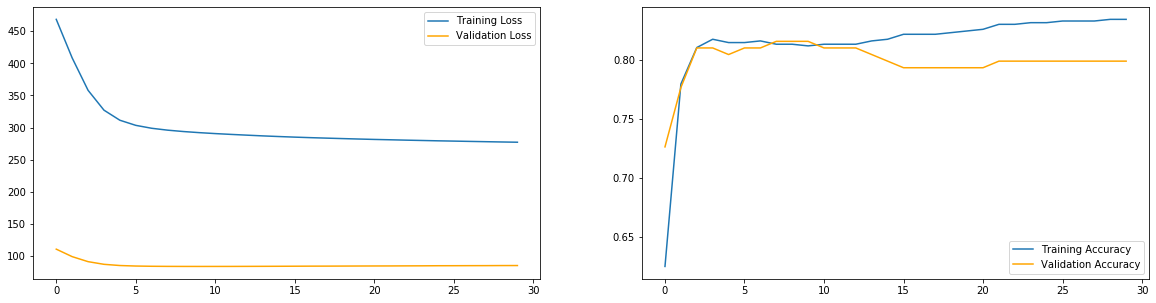

Start training at fold: 2...
Epoch: (1/30), Train loss: 490.568451, Train Acc: 0.568022, Val loss: 107.914223, Val Acc: 0.735955
Epoch: (2/30), Train loss: 411.716248, Train Acc: 0.737728, Val loss: 94.810951, Val Acc: 0.808989
Epoch: (3/30), Train loss: 365.103424, Train Acc: 0.775596, Val loss: 87.253517, Val Acc: 0.814607
Epoch: (4/30), Train loss: 339.385895, Train Acc: 0.784011, Val loss: 83.415512, Val Acc: 0.814607
Epoch: (5/30), Train loss: 325.202332, Train Acc: 0.795231, Val loss: 81.576180, Val Acc: 0.803371
Epoch: (6/30), Train loss: 316.869446, Train Acc: 0.799439, Val loss: 80.737854, Val Acc: 0.803371
Epoch: (7/30), Train loss: 311.395813, Train Acc: 0.798036, Val loss: 80.329002, Val Acc: 0.808989
Epoch: (8/30), Train loss: 307.237061, Train Acc: 0.805049, Val loss: 80.227844, Val Acc: 0.814607
Epoch: (9/30), Train loss: 303.840454, Train Acc: 0.806452, Val loss: 80.267685, Val Acc: 0.814607
Epoch: (10/30), Train loss: 301.051361, Train Acc: 0.809257, Val loss: 80.32988

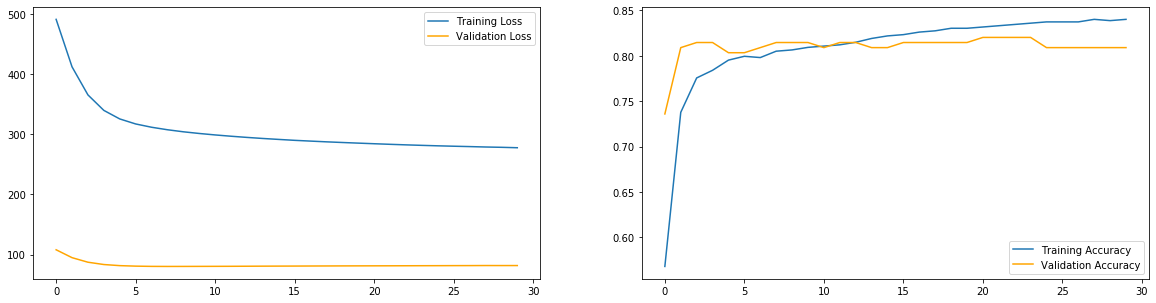

Start training at fold: 3...
Epoch: (1/30), Train loss: 472.033325, Train Acc: 0.621318, Val loss: 110.019882, Val Acc: 0.764045
Epoch: (2/30), Train loss: 399.930939, Train Acc: 0.782609, Val loss: 96.524162, Val Acc: 0.792135
Epoch: (3/30), Train loss: 352.200653, Train Acc: 0.813464, Val loss: 88.471245, Val Acc: 0.764045
Epoch: (4/30), Train loss: 325.799072, Train Acc: 0.814867, Val loss: 84.621628, Val Acc: 0.775281
Epoch: (5/30), Train loss: 312.679382, Train Acc: 0.814867, Val loss: 82.817223, Val Acc: 0.769663
Epoch: (6/30), Train loss: 305.692963, Train Acc: 0.817672, Val loss: 81.884003, Val Acc: 0.786517
Epoch: (7/30), Train loss: 301.529480, Train Acc: 0.823282, Val loss: 81.340866, Val Acc: 0.786517
Epoch: (8/30), Train loss: 298.792969, Train Acc: 0.823282, Val loss: 80.954514, Val Acc: 0.786517
Epoch: (9/30), Train loss: 296.746857, Train Acc: 0.827489, Val loss: 80.637337, Val Acc: 0.792135
Epoch: (10/30), Train loss: 295.099792, Train Acc: 0.827489, Val loss: 80.34400

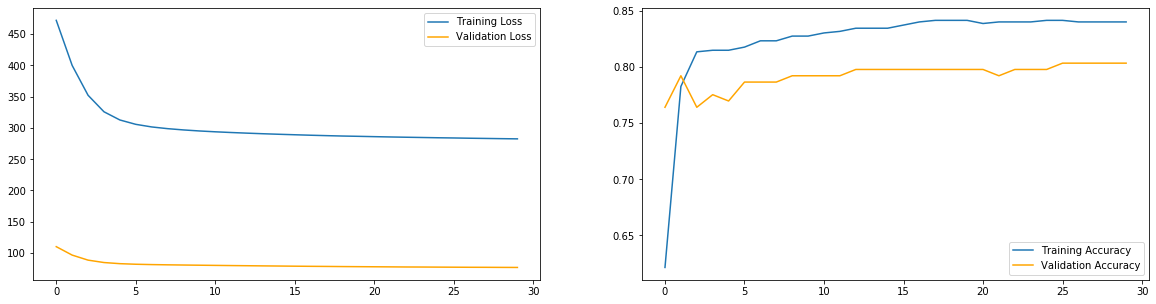

Start training at fold: 4...
Epoch: (1/30), Train loss: 451.495850, Train Acc: 0.621318, Val loss: 106.707344, Val Acc: 0.595506
Epoch: (2/30), Train loss: 402.568604, Train Acc: 0.659187, Val loss: 100.109146, Val Acc: 0.702247
Epoch: (3/30), Train loss: 375.019287, Train Acc: 0.758766, Val loss: 96.579033, Val Acc: 0.775281
Epoch: (4/30), Train loss: 355.300842, Train Acc: 0.795231, Val loss: 94.079857, Val Acc: 0.775281
Epoch: (5/30), Train loss: 340.079071, Train Acc: 0.810659, Val loss: 92.292389, Val Acc: 0.764045
Epoch: (6/30), Train loss: 329.083466, Train Acc: 0.806452, Val loss: 91.180923, Val Acc: 0.764045
Epoch: (7/30), Train loss: 321.398529, Train Acc: 0.806452, Val loss: 90.442711, Val Acc: 0.764045
Epoch: (8/30), Train loss: 316.013275, Train Acc: 0.806452, Val loss: 89.956215, Val Acc: 0.764045
Epoch: (9/30), Train loss: 312.141144, Train Acc: 0.803647, Val loss: 89.635529, Val Acc: 0.764045
Epoch: (10/30), Train loss: 309.084045, Train Acc: 0.802244, Val loss: 89.4243

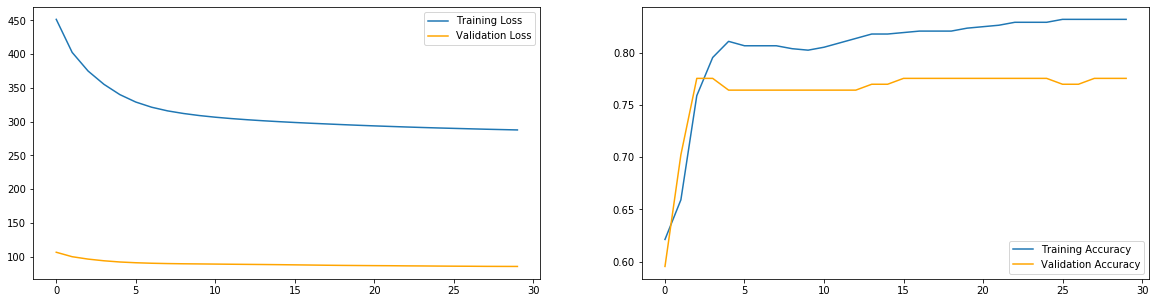

Start training at fold: 5...
Epoch: (1/30), Train loss: 476.136780, Train Acc: 0.671809, Val loss: 109.062698, Val Acc: 0.808989
Epoch: (2/30), Train loss: 422.033264, Train Acc: 0.781206, Val loss: 93.791183, Val Acc: 0.837079
Epoch: (3/30), Train loss: 379.625854, Train Acc: 0.793829, Val loss: 82.787392, Val Acc: 0.837079
Epoch: (4/30), Train loss: 351.971741, Train Acc: 0.788219, Val loss: 76.233490, Val Acc: 0.837079
Epoch: (5/30), Train loss: 336.574005, Train Acc: 0.789621, Val loss: 72.552704, Val Acc: 0.831461
Epoch: (6/30), Train loss: 328.336334, Train Acc: 0.789621, Val loss: 70.340965, Val Acc: 0.831461
Epoch: (7/30), Train loss: 323.499084, Train Acc: 0.795231, Val loss: 68.927956, Val Acc: 0.831461
Epoch: (8/30), Train loss: 320.353271, Train Acc: 0.795231, Val loss: 67.873428, Val Acc: 0.831461
Epoch: (9/30), Train loss: 318.041046, Train Acc: 0.796634, Val loss: 67.065247, Val Acc: 0.837079
Epoch: (10/30), Train loss: 316.256104, Train Acc: 0.799439, Val loss: 66.40642

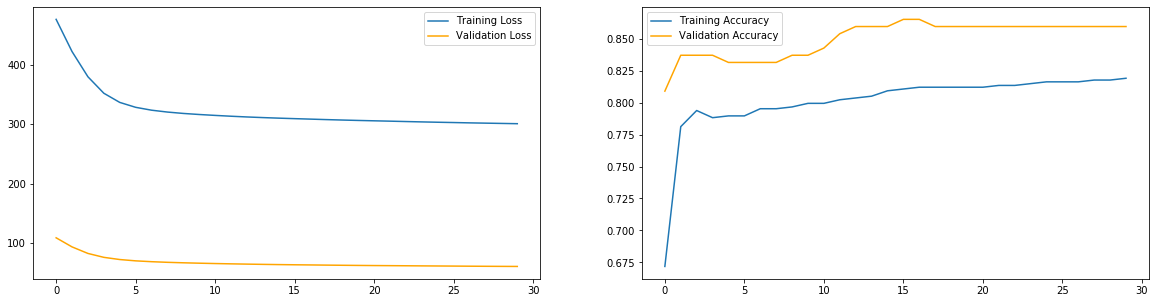

Best fold: 5


In [21]:
best_model = LinearRegression(NUM_PARAMETER).to(device)
if TRAIN_DATA:
    EPOCHS = 30
    best_val_acc = 0
    best_fold = 0
    kf = KFold(n_splits=5)
    for fold, (train_id, val_id) in enumerate(kf.split(X)):
        X_train , X_val = X[train_id], X[val_id]
        y_train, y_val = Y[train_id], Y[val_id]
        
        trainset = data.TensorDataset(torch.from_numpy(X_train), torch.LongTensor(torch.from_numpy(y_train)))
        valset = data.TensorDataset(torch.from_numpy(X_val), torch.LongTensor(torch.from_numpy(y_val)))
        
        trainloader = data.DataLoader(trainset, num_workers= 4, batch_size=1)
        valloader = data.DataLoader(valset, num_workers= 4, batch_size=1)
        
        model = LinearRegression(NUM_PARAMETER).to(device)
        error = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr= 0.0002, weight_decay = 1e-5)
        print("Start training at fold: {}...".format(fold+1))
        model, train_loss_list, train_acc_list, val_loss_list, val_acc_list = train(EPOCHS,model,optimizer,error,trainloader,valloader)
        print("Fold {} completed! Plotting...".format(fold+1))
        plot(train_loss_list, train_acc_list, val_loss_list, val_acc_list, EPOCHS)
        if val_acc_list[-1] > best_val_acc:
            best_val_acc = val_acc_list[-1]
            torch.save(model.state_dict(), "model/model2.pth")
            best_model = model
            best_fold = fold+1
    
    print("Best fold: {}".format(best_fold))

In [22]:
def predict(model, X):
    model.eval()
    prediction = []
    with torch.no_grad():
        X = Variable(torch.from_numpy(X)).view(-1,NUM_PARAMETER).to(device)
        outputs = model(X)
        prediction = [1 if i > 0.5 else 0 for i in outputs.data]
    return prediction

In [23]:
table_test = pd.read_csv(TEST_DIR)
#display(HTML(table_test.to_html()))

In [38]:
table_test = table_test.fillna(table.mean()) #Fill NaN cells with mean of the row
X_label = table_test["PassengerId"]
X_test = table_test.drop(["Name","Ticket","PassengerId","Embarked","Cabin"],axis = 1)
X_test.replace({'Sex':{'male' : 1, 'female': 0}},inplace = True)
X_test = np.array(X_test).astype(np.float32)
X_test = make_feature(X_test,2)
X_test = Normalize_data(X_test)
X_label = np.array(X_label)

In [39]:
from tqdm import tqdm

In [41]:
if not TRAIN_DATA:
    best_model.load_state_dict(torch.load("model/model2.pth"))
result = predict(best_model,X_test)
with open("predict.csv", "w", newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["PassengerID", "Survived"])
    for (i,j) in tqdm(zip(X_label,result)):
        writer.writerow([i,j])

418it [00:00, 430872.22it/s]
